## Problem Set #5

MACS 30100, Dr. Evans
<br>
Due Monday, Feb. 19 at 11:30am
<br>
Liqiang Yu

### Problem 1
Multinomial logistic regression and cross validation (6 points).

(a) Estimate the model on a 75% sample training set using the following command. Report your two sets of estimated coeﬃcients for j = 1 and j = 2. Report your error rates (1 - precision) on the test set using the code below. Which category of cultivar is the model best at predicting? Is the most accurately predicted category the one with the most observations?

In [88]:
import pandas as pd
from sklearn.cross_validation import train_test_split 
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

drink = pd.read_csv('./data/strongdrink.txt', sep = ',')
X = drink[['alco', 'malic', 'tot_phen', 'color_int']]
y = drink['cultivar']
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size = 0.25, random_state=20)
MultLogReg = LogisticRegression(multi_class='multinomial',
                                solver='newton-cg')
MultLogReg = MultLogReg.fit(X_train, y_train)

In [89]:
import numpy as np

y_pred = MultLogReg.predict(X_test)
coef = pd.DataFrame(MultLogReg.coef_[0:2], index \
     = ["cultivar = 1", "cultivar = 2"], columns = X.columns)
coef.loc[:,"Intercept"] = MultLogReg.intercept_[:2]
err_rate = pd.DataFrame({"error rate":[0.13, 0, 0]},index = \
        ["cultivar = 1", "cultivar = 2", "cultivar = 3"])
print('The estimated coefficients for j = 1 and j = 2 are:\n',coef)
print('\nThe error rates are: \n', err_rate)
print('\n',classification_report(y_test, y_pred))
print('The best predicted category is cultivar = 3' + '\n' +
      'while it has the fewest observations:\n',drink.cultivar.value_counts(),\
     '\n',y_test.value_counts())

The estimated coefficients for j = 1 and j = 2 are:
                   alco     malic  tot_phen  color_int  Intercept
cultivar = 1  1.700370 -0.265602  1.223892   0.022762 -24.010571
cultivar = 2 -1.468065 -0.333055  0.664017  -0.922714  22.802707

The error rates are: 
               error rate
cultivar = 1        0.13
cultivar = 2        0.00
cultivar = 3        0.00

              precision    recall  f1-score   support

          1       0.87      1.00      0.93        13
          2       1.00      0.90      0.95        21
          3       1.00      1.00      1.00        10

avg / total       0.96      0.95      0.96        44

The best predicted category is cultivar = 3
while it has the fewest observations:
 2    71
1    59
3    46
Name: cultivar, dtype: int64 
 2    21
1    13
3    10
Name: cultivar, dtype: int64


(b) Perform a leave-one-out cross validation (LOOCV) with the model from part (a). Report your error rates (1 - precision) for each category? How do your error rates compare to those from part (a)? Report your LOOCV estimate for the test MSE as the average MSE, where y i is the left out observation from each test set.

In [90]:
from sklearn.model_selection import LeaveOneOut
Xvars = X.values
yvals = y.values
N_loo = Xvars.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(Xvars)
MSE_vec = np.zeros(N_loo)
result = np.empty((N_loo,2))

for train_index, test_index in loo.split(Xvars):
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    LogReg = LogisticRegression(multi_class='multinomial',
                                solver='newton-cg')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    if y_pred == y_test:
        MSE_vec[test_index] = 0
    else:
        MSE_vec[test_index] = 1   
    result[test_index,:] = np.array([y_test, y_pred]).reshape((1,2))

MSE_loo = MSE_vec.mean()
err_rate_loo = pd.DataFrame({"error rate":[0.10, 0.09, 0.04]},index = \
        ["cultivar = 1", "cultivar = 2", "cultivar = 3"])

print('\nThe error rates are: \n', err_rate_loo)
print(classification_report(result[:,0], result[:,1]))
print('For cultivar = 2 and cultivar = 3, the error rate of each increases \
while the error rate of cultivar = 1 decreases.\n')
print('Test estimate MSE loocvv =',MSE_loo)


The error rates are: 
               error rate
cultivar = 1        0.10
cultivar = 2        0.09
cultivar = 3        0.04
             precision    recall  f1-score   support

        1.0       0.90      0.93      0.92        59
        2.0       0.91      0.90      0.91        71
        3.0       0.96      0.93      0.95        46

avg / total       0.92      0.92      0.92       176

For cultivar = 2 and cultivar = 3, the error rate of each increases while the error rate of cultivar = 1 decreases.

Test estimate MSE loocvv = 0.07954545454545454


(c) Perform a k-fold cross validation in which the data are divided into k = 4 groups. Use the following code. Report your error rates (1 - precision) for each category. How do your error rates compare to those from parts (a) and (b)? Report your k-fold estimate for the test MSE as the average MSE.

In [91]:
from sklearn.model_selection import KFold

k = 4
kf = KFold(n_splits=k, random_state=10, shuffle=True)
kf.get_n_splits(Xvars)
N = drink.shape[0]
MSE_vec_kf = np.zeros(k)
classify_kf = np.empty((N, 2))

k_ind = 0
for train_index, test_index in kf.split(Xvars):
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    LogReg = LogisticRegression(multi_class='multinomial',
                                solver='newton-cg')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    MSE_vec_kf[k_ind] = (y_test != y_pred).mean()
    classify_kf[test_index,0:1] = np.array([y_test]).reshape((44,1))
    classify_kf[test_index,1] = y_pred
    print('k index=', k_ind)
    print(classification_report(y_test, y_pred))
    k_ind += 1

err_rate_kf = pd.DataFrame({"error rate":[0.13, 0.09, 0.04]},index = \
        ["cultivar = 1", "cultivar = 2", "cultivar = 3"])
for i in range(0,4):
    print('MSE for test set', i, ' is', MSE_vec_kf[i])
print('The test estimate (average) MSE k-fold is', MSE_vec_kf.mean(),'\n')
print('For the final result\n',classification_report(classify_kf[:,0], classify_kf[:,1]))
print('\nThe error rates are: \n', err_rate_kf)
print('The error rates are larger than part (a) and part(b), which means that the result is worse. \
However, tt shows that the category with largest number of observations does not usually have the best predictive result.')

k index= 0
             precision    recall  f1-score   support

          1       0.71      1.00      0.83        12
          2       1.00      0.75      0.86        24
          3       0.78      0.88      0.82         8

avg / total       0.88      0.84      0.84        44

k index= 1
             precision    recall  f1-score   support

          1       1.00      0.76      0.87        17
          2       0.69      1.00      0.81        11
          3       1.00      0.94      0.97        16

avg / total       0.92      0.89      0.89        44

k index= 2
             precision    recall  f1-score   support

          1       0.94      1.00      0.97        15
          2       0.94      0.94      0.94        16
          3       1.00      0.92      0.96        13

avg / total       0.96      0.95      0.95        44

k index= 3
             precision    recall  f1-score   support

          1       0.88      1.00      0.94        15
          2       1.00      0.90      0.95   

### Problem 2
Splines and interpolation (4 points).

(a) Create a scatterplot of the data with age on the x-axis and Coolness Index on the y-axis. Label your axes, and give the plot a title.

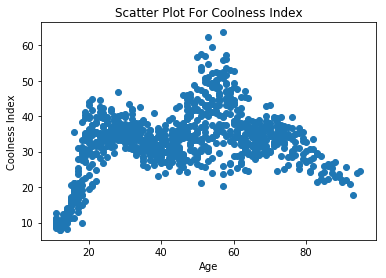

In [92]:
import matplotlib.pyplot as plt

cool_data = pd.read_csv('./data/CoolIndex.txt', header=None, names = ['age', "cool"])
plt.scatter(x =cool_data['age'], y =cool_data['cool'])
plt.title('Scatter Plot For Coolness Index', fontsize=12)
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.show()

(b) Use ordinary least squares (OLS) regression to ﬁt a stepwise function to these data. Use 5 bins [11, 22), [22, 40), [40, 59), [59, 77), [77, 95]. Remember that your dummy variables must be integer type (0, 1), not boolean type (True, False). Plot this step function on top of the scatterplot of the data from part (a). Label your axes, include a legend, and give the plot a title. Report your estimated step function values for each bin [β 1 , β 2 , β 3 , β 4 , β 5 ]. What is the predicted coolness of a 73-year old from the stepwise function?

In [93]:
import statsmodels.api as sm

age = cool_data['age']
cool = cool_data['cool']
age_bin1 = ((age >= 11) & (age < 22)).astype(int)
age_bin2 = ((age >= 22) & (age < 40)).astype(int)
age_bin3 = ((age >= 40) & (age < 59)).astype(int)
age_bin4 = ((age >= 59) & (age < 77)).astype(int)
age_bin5 = ((age >= 77) & (age < 95) ).astype(int)
X_step = pd.DataFrame(dict(age_bin1=age_bin1, age_bin2=age_bin2,
                           age_bin3=age_bin3, age_bin4=age_bin4,
                           age_bin5=age_bin5))
X_step.describe()

,age_bin1,age_bin2,age_bin3,age_bin4,age_bin5
count,956.000000,956.000000,956.000000,956.000000,956.000000
mean,0.162134,0.276151,0.285565,0.217573,0.057531
std,0.368767,0.447326,0.451919,0.412812,0.232977
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


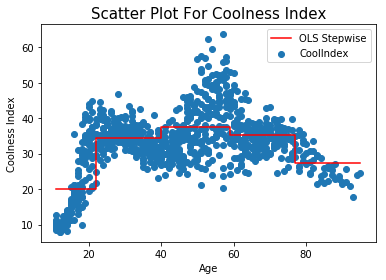

                            OLS Regression Results                            
Dep. Variable:                   cool   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     4280.
Date:                Mon, 19 Feb 2018   Prob (F-statistic):               0.00
Time:                        10:39:08   Log-Likelihood:                -3220.5
No. Observations:                 956   AIC:                             6451.
Df Residuals:                     951   BIC:                             6475.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age_bin1      20.1025      0.566     35.522      0.0

In [94]:
reg = sm.OLS(endog=cool, exog=X_step, missing='drop')
reg_results = reg.fit()

x = [11, 22, 40, 59, 77, 95]
y = reg2_results.params.tolist() + [reg2_results.params[-1]]
ax = plt.axes()
plt.scatter(x =cool_data['age'], y =cool_data['cool'], label='CoolIndex')
ax.set_title('Scatter Plot For Coolness Index', fontsize=15)
ax.set_xlabel('Age')
ax.set_ylabel('Coolness Index')
ax.plot()

ax.step(x, y, where = 'post', color="r", label = 'OLS Stepwise')
plt.legend()
plt.show()
print(reg2_results.summary())
print('The estimated step function values for each bin are:',reg_results.params)
print('\nThe predicted coolness of a 73-year old from the stepwise function is ', reg_results.params[3])

(c) Fit a linear spline (continuous) to the data over the 5 age bins from part (b). Use the scipy.interpolate.LQUnivariateSpline function with k = 1 (linear) and the knots equal to t =[22,40,59,77]. Plot your continuous linear spline against a scatterplot of the data from part (a) and the estimated step function from part (b). Label your axes, include a legend, and give the plot a title. What is the predicted coolness of a 73-year old from the linear spline?

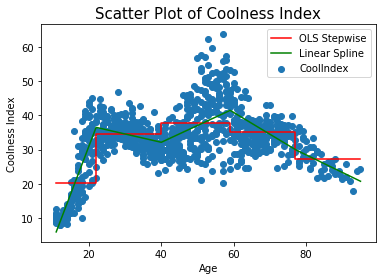


The predicted coolness of a 73-year old from the linear spline is 32.536832389143306


In [95]:
from scipy.interpolate import LSQUnivariateSpline
knots = [22, 40, 59, 77]
spl_cool_1 = LSQUnivariateSpline(age.values, cool.values, knots, k=1)
spl_cool_3 = LSQUnivariateSpline(age.values, cool.values, knots, k=3)
age_vec = np.linspace(age.values.min(), age.values.max(), 1000)

x = [11, 22, 40, 59, 77, 95]
y = reg_results.params.tolist() + [reg_results.params[-1]]
ax = plt.axes()
plt.scatter(x =cool_data['age'], y =cool_data['cool'], label='CoolIndex')
ax.set_title('Scatter Plot of Coolness Index', fontsize=15)
ax.set_xlabel('Age')
ax.set_ylabel('Coolness Index')
ax.plot(color='blue')

ax.step(x, y, where = 'post', color="r", label = 'OLS Stepwise')
plt.plot(age_vec, spl_cool_1(age_vec), 'g-', label='Linear Spline')
plt.legend()
plt.show()

ages_for_predict = 73
linear_predicted_wages = spl_cool_1(ages_for_predict)
print('\nThe predicted coolness of a 73-year old from the linear spline is', linear_predicted_wages)

(d) Fit a cubic spline (continuous) to the data over the 5 age bins from part (b). Use the scipy.interpolate.LQUnivariateSpline function with k = 3 (cubic) and the knots equal to t =[22,40,59,77]. Plot your continuous cubic spline against a scatterplot of the data from part (a) and the estimated step function from part (b), and the linear spline from part (c). Label your axes, include a legend, and give the plot a title. What is the predicted coolness of a 73-year old from the cubic spline?

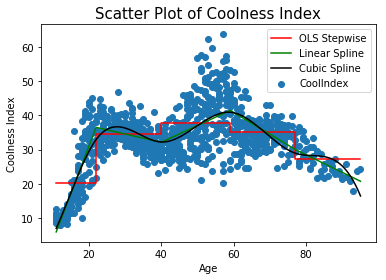


The predicted coolness of a 73-year old from the cubic spline is 31.262429389257864


In [97]:
x = [11, 22, 40, 59, 77, 95]
y = reg2_results.params.tolist() + [reg2_results.params[-1]]
ax = plt.axes()
plt.scatter(x =cool_data['age'], y =cool_data['cool'], label='CoolIndex')
ax.set_title('Scatter Plot of Coolness Index', fontsize=15)
ax.set_xlabel('Age')
ax.set_ylabel('Coolness Index')
ax.plot(color='blue')

ax.step(x, y, where = 'post', color="r", label = 'OLS Stepwise')
plt.plot(age_vec, spl_cool_1(age_vec), 'g-', label='Linear Spline')
plt.plot(age_vec, spl_cool_3(age_vec), 'black', label='Cubic Spline')
plt.legend()
plt.show()

predicted_age3 = spl_cool_3(73)
print('\nThe predicted coolness of a 73-year old from the cubic spline is', predicted_age3)